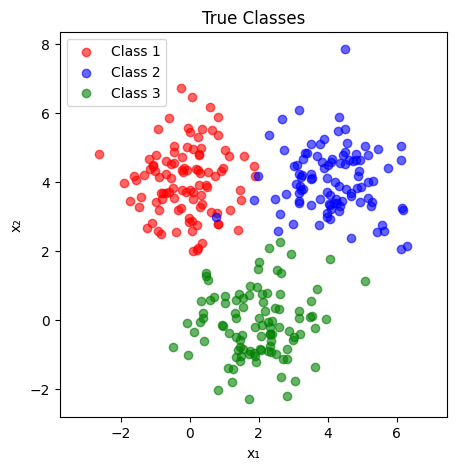

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 재현성을 위해 시드(seed) 고정
# ------------------------------------------------------------
# np.random.seed: 같은 난수 시퀀스를 반복해서 생성하도록 고정
np.random.seed(42)

# ------------------------------------------------------------
# 1) 클래스별 평균 벡터(mu)와 공분산 행렬(Sigma) 정의
# ------------------------------------------------------------
mu1 = np.array([0, 4])   # 클래스1의 평균 (x₁=0, x₂=4)
mu2 = np.array([4, 4])   # 클래스2의 평균 (x₁=4, x₂=4)
mu3 = np.array([2, 0])   # 클래스3의 평균 (x₁=2, x₂=0)

# 공분산 행렬: 단위 행렬(identity)
# → 두 차원 간 독립(공분산=0), 각 차원 분산=1
Sigma = np.eye(2)

# ------------------------------------------------------------
# 2) 다변량 정규분포에서 각 클래스별 샘플 100개씩 생성
# ------------------------------------------------------------
# np.random.multivariate_normal(mean, cov, size):
#   mean: 평균 벡터 (d,)
#   cov: 공분산 행렬 (d×d)
#   size: 생성할 샘플 개수
X1 = np.random.multivariate_normal(mu1, Sigma, 100)
X2 = np.random.multivariate_normal(mu2, Sigma, 100)
X3 = np.random.multivariate_normal(mu3, Sigma, 100)

# ------------------------------------------------------------
# 3) 세 클래스를 하나의 배열 X에 수직으로 합치기
# ------------------------------------------------------------
# X1, X2, X3: 각각 (100,2) 배열
# np.vstack: 수직(vertical) 방향으로 이어붙여 (300,2) 배열 생성
X = np.vstack([X1, X2, X3])

# ------------------------------------------------------------
# 4) 생성된 데이터 산점도로 시각화
# ------------------------------------------------------------
plt.figure(figsize=(5,5))  # 그래프 캔버스 크기 설정 (인치 단위)

# 클래스1 산점도: 빨간색, 투명도 α=0.6
plt.scatter(
    X1[:,0], X1[:,1],      # X1의 모든 행에서 첫 번째(col=0), 두 번째(col=1) 열
    c='r',                 # color: red
    alpha=0.6,             # 투명도
    label='Class 1'        # 범례 레이블
)

# 클래스2 산점도: 파란색
plt.scatter(
    X2[:,0], X2[:,1],
    c='b',
    alpha=0.6,
    label='Class 2'
)

# 클래스3 산점도: 초록색
plt.scatter(
    X3[:,0], X3[:,1],
    c='g',
    alpha=0.6,
    label='Class 3'
)

# ------------------------------------------------------------
# 5) 그래프 꾸미기
# ------------------------------------------------------------
plt.legend()
plt.title('True Classes') # 제목 설정
plt.xlabel('x₁')          # x축 레이블
plt.ylabel('x₂')          # y축 레이블
plt.axis('equal')         # x, y 축 비율(스케일)을 동일하게 유지
plt.show()                # 그래프 렌더링

In [ ]:
def my_pca(X, n_components):
    """
    간단한 PCA 구현 함수
    --------------------------------------------
    Args:
        X (ndarray): 원본 데이터 행렬, shape = (n_samples, n_features)
        n_components (int): 투영할 주성분의 개수

    Returns:
        X_reduced (ndarray): 차원 축소된 데이터, shape = (n_samples, n_components)
        principal_vectors (ndarray): 선택된 주성분 벡터들, shape = (n_features, n_components)
        principal_values (ndarray): 선택된 주성분의 고유값들, shape = (n_components,)
    """

    # ------------------------------------------------------------
    # 1) 데이터 중앙화 (Centering)
    # ------------------------------------------------------------
    # X.mean(axis=0)는 각 feature(열)별 평균을 계산하여 (n_features,) 형태의 벡터를 반환
    X_mean = X.mean(axis=0)       # 전체 샘플에 대한 feature 별 평균
    Xc = X - X_mean               # 원본 데이터에서 평균을 빼서 중앙화된 데이터 생성

    # ------------------------------------------------------------
    # 2) 공분산 행렬 (Covariance Matrix) 계산
    # ------------------------------------------------------------
    # 공분산 행렬 C = (Xcᵀ @ Xc) / (n_samples - 1)
    #   - Xc.T @ Xc: feature 간 공분산의 합계를 구함
    #   - 분모를 (n_samples - 1)로 나누어 표본 공분산을 계산
    n_samples = Xc.shape[0]       # 샘플(데이터 포인트) 개수
    C = (Xc.T @ Xc) / (n_samples - 1)

    # ------------------------------------------------------------
    # 3) 고유값 분해 (Eigen-decomposition)
    # ------------------------------------------------------------
    # np.linalg.eigh: 실칭 대칭행렬(공분산 행렬)의 고유값과 고유벡터를 계산
    #   - eigvals: 고유값 배열, 길이 = n_features
    #   - eigvecs: 고유벡터 행렬, shape = (n_features, n_features)
    eigvals, eigvecs = np.linalg.eigh(C)

    # ------------------------------------------------------------
    # 4) 고유값 내림차순으로 정렬 (Sort eigenvalues descending)
    # ------------------------------------------------------------
    # 기본적으로 eigh가 반환한 eigvals는 오름차순 정렬되어 있으므로,
    # np.argsort(...)[::-1]을 통해 내림차순 인덱스를 얻어 재정렬
    idx_desc = np.argsort(eigvals)[::-1]  # 고유값을 내림차순으로 정렬할 인덱스
    eigvals = eigvals[idx_desc]           # 내림차순 정렬된 고유값
    eigvecs = eigvecs[:, idx_desc]        # 동일 순서로 재정렬된 고유벡터 행렬

    # ------------------------------------------------------------
    # 5) 차원 축소 (Projection onto principal components)
    # ------------------------------------------------------------
    # 상위 n_components개의 고유벡터(principal_vectors)를 선택하여
    # 중앙화된 데이터를 이 벡터들에 투영
    principal_vectors = eigvecs[:, :n_components]  # shape = (n_features, n_components)
    X_reduced = Xc @ principal_vectors             # shape = (n_samples, n_components)

    return X_reduced, principal_vectors, eigvals[:n_components]


# ----------------------------------------
# 사용 예시: 2차원 → 1차원 PCA 수행
# ----------------------------------------
# X      : (300, 2) 크기의 원본 데이터 (1)에서 생성된 합쳐진 데이터
# n_comp : 투영할 주성분 개수 (여기서는 1)
X1d, pcs, vals = my_pca(X, 1)

# 첫 번째 주성분의 고유값 출력
print("첫 번째 주성분 고유값:", vals[0])

첫 번째 주성분 고유값: 4.801300439159481


K-means 수렴: 반복 3회, 중심 이동량 0.00000


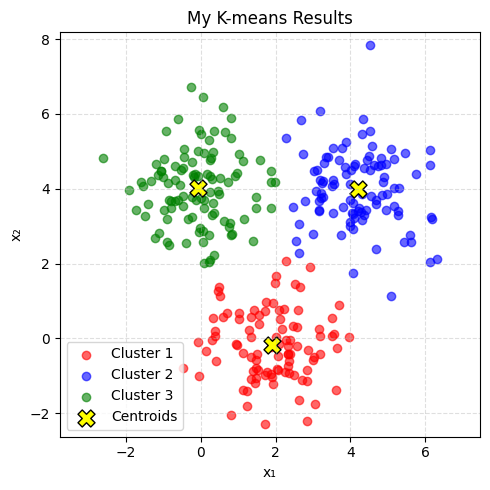

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def my_kmeans(X, K, max_iter=100, tol=1e-4):
    # ------------------------------------------------------------
    # 0) 변수 초기화
    # ------------------------------------------------------------
    n, d = X.shape
    #   n: 샘플 개수, d: 특성(차원) 개수

    # 랜덤 시드를 고정하여 항상 동일한 초기 중심 선택
    rng = np.random.RandomState(0)

    # 1) 초기 중심(center) 설정
    #    - 데이터 X 중에서 중복되지 않게 K개의 샘플을 무작위로 뽑음
    #    - replace=False를 통해 같은 샘플을 두 번 고르지 않음
    centers = X[rng.choice(n, K, replace=False)]

    # 레이블 배열 초기화 (모두 0으로 시작)
    labels = np.zeros(n, dtype=int)

    # ------------------------------------------------------------
    # 2) 반복 수행: 할당 단계 → 갱신 단계 → 수렴 검사
    # ------------------------------------------------------------
    for it in range(max_iter):
        # (2-1) 할당 단계 (Assignment step)
        # 각 샘플과 각 중심 간의 유클리드 거리 계산
        #   - X[:, None]: shape (n, 1, d)
        #   - centers[None, :]: shape (1, K, d)
        #   - 두 차원 브로드캐스트 후 차원별 거리 계산 → shape (n, K)
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)

        # 각 샘플이 가장 가까운 중심의 인덱스를 labels로 저장
        new_labels = np.argmin(dists, axis=1)

        # (2-2) 갱신 단계 (Update step)
        # 각 클러스터 k에 대해, 할당된 샘플들의 평균을 계산하여 새로운 중심으로 설정
        new_centers = np.array([
            # np.any(new_labels==k): 클러스터 k에 속한 샘플이 하나라도 있는지 확인
            X[new_labels == k].mean(axis=0)
            if np.any(new_labels == k) else      # 만약 빈 클러스터라면
            centers[k]                            # 이전 중심 그대로 유지
            for k in range(K)
        ])

        # (2-3) 수렴 검사 (Convergence check)
        #  - 레이블이 이전과 동일하거나 중심 이동 크기가 tol 이하이면 반복 종료
        center_shift = np.linalg.norm(new_centers - centers)
        if np.all(new_labels == labels) or center_shift < tol:
            # 수렴 상황: 반복문 탈출
            print(f"K-means 수렴: 반복 {it+1}회, 중심 이동량 {center_shift:.5f}")
            break

        # 준비 단계: 레이블과 중심을 갱신하여 다음 반복으로 넘어감
        labels = new_labels
        centers = new_centers

    return labels, centers


# ------------------------------------------------------------
# 실행 및 결과 시각화
# ------------------------------------------------------------
# my_kmeans 호출: X 데이터에 대해 3개의 클러스터로 군집화 수행
labels, centers = my_kmeans(X, K=3)

# 결과 플롯: 각 클러스터 샘플과 최종 중심 표시
plt.figure(figsize=(5,5))
colors = ['r', 'b', 'g']

for k in range(3):
    # 클러스터 k에 할당된 샘플 좌표만 추출
    pts = X[labels == k]
    plt.scatter(
        pts[:, 0], pts[:, 1],   # x₁ 좌표, x₂ 좌표
        c=colors[k],            # 색상 설정
        alpha=0.6,              # 점 투명도
        label=f'Cluster {k+1}'
    )

# 최종 중심을 노란색 X 마커로 표시
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='yellow',                # 마커 내부 색
    edgecolor='k',             # 테두리 검은색
    marker='X',                # X 모양 마커
    s=150,                     # 마커 크기
    label='Centroids'
)

# 그래프 꾸미기
plt.title('My K-means Results')  # 제목
plt.xlabel('x₁')                 # x축 레이블
plt.ylabel('x₂')                 # y축 레이블
plt.axis('equal')                # x/y 축 동일 비율
plt.legend(loc='best')           # 범례
plt.grid(True, linestyle='--', alpha=0.4)  # 가독성 위한 그리드
plt.tight_layout()
plt.show()

<ipython-input-8-101375168c66>:84: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                            # 레이아웃 간격 자동 조정
<ipython-input-8-101375168c66>:84: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                            # 레이아웃 간격 자동 조정
<ipython-input-8-101375168c66>:84: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                            # 레이아웃 간격 자동 조정
<ipython-input-8-101375168c66>:84: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                            # 레이아웃 간격 자동 조정
<ipython-input-8-101375168c66>:84: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                            # 레이아웃 간격 자동 조정
<ipython-input-8-101375168c66>:84: UserWarning: Glyph 54540 (\N{HANGUL SYLLABL

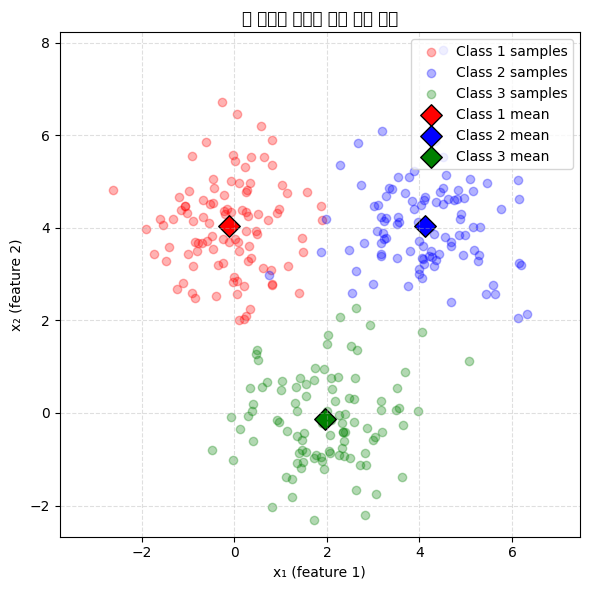

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) 클래스별 샘플 평균 계산
# ------------------------------------------------------------
# np.mean: 배열의 지정된 축(axis)을 따라 평균을 계산하는 함수
# axis=0 으로 지정하면 "각 칼럼(column)" 즉, 각 차원별 평균을 구함
mu1_emp = np.mean(X1, axis=0)   # 클래스1(X1)의 x₁, x₂ 평균 → shape (2,)
mu2_emp = np.mean(X2, axis=0)   # 클래스2(X2)의 x₁, x₂ 평균
mu3_emp = np.mean(X3, axis=0)   # 클래스3(X3)의 x₁, x₂ 평균

# ------------------------------------------------------------
# 2) 원본 샘플 산점도 그리기 (투명도 α=0.3)
# ------------------------------------------------------------
# plt.figure: 새로운 캔버스(그래프 영역) 생성
plt.figure(figsize=(6,6))       # 가로×세로 6인치 크기로 설정

# 클래스1 샘플: 빨간색, 투명도 0.3
plt.scatter(
    X1[:,0],       # 모든 샘플의 첫 번째 차원(x₁)
    X1[:,1],       # 모든 샘플의 두 번째 차원(x₂)
    c='red',       # 점 색상
    alpha=0.3,     # 투명도(0~1)
    label='Class 1 samples'  # 범례(label)
)

# 클래스2 샘플: 파란색, 투명도 0.3
plt.scatter(
    X2[:,0], X2[:,1],
    c='blue',
    alpha=0.3,
    label='Class 2 samples'
)

# 클래스3 샘플: 초록색, 투명도 0.3
plt.scatter(
    X3[:,0], X3[:,1],
    c='green',
    alpha=0.3,
    label='Class 3 samples'
)

# ------------------------------------------------------------
# 3) 각 클래스 샘플 평균점 표시
# ------------------------------------------------------------
# 평균점은 Marker를 'D'(다이아몬드)로, 테두리를 검은색으로 강조
plt.scatter(
    mu1_emp[0], mu1_emp[1],  # 클래스1 평균 좌표
    c='red',                # 내부 색상
    marker='D',             # 다이아몬드 모양 마커
    s=120,                  # 마커 크기(size)
    edgecolor='black',      # 테두리 색상
    label='Class 1 mean'
)

plt.scatter(
    mu2_emp[0], mu2_emp[1],
    c='blue',
    marker='D',
    s=120,
    edgecolor='black',
    label='Class 2 mean'
)

plt.scatter(
    mu3_emp[0], mu3_emp[1],
    c='green',
    marker='D',
    s=120,
    edgecolor='black',
    label='Class 3 mean'
)

# ------------------------------------------------------------
# 4) 그래프 꾸미기
# ------------------------------------------------------------
plt.axis('equal')                             # x, y 축 비율을 동일하게 설정
plt.xlabel('x₁ (feature 1)')                  # x축 라벨
plt.ylabel('x₂ (feature 2)')                  # y축 라벨
plt.title('각 클래스 샘플과 샘플 평균 위치')         # 그래프 제목
plt.legend(loc='upper right', fontsize=10)    # 범례 표시 (위쪽 오른쪽)
plt.grid(True, linestyle='--', alpha=0.4)     # 가독성을 위한 그리드 추가
plt.tight_layout()                            # 레이아웃 간격 자동 조정
plt.show()

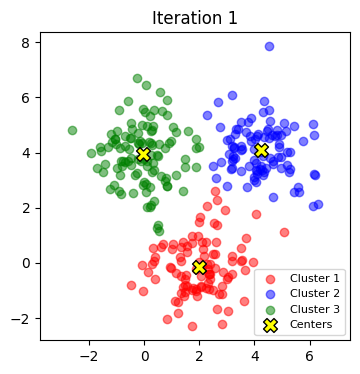

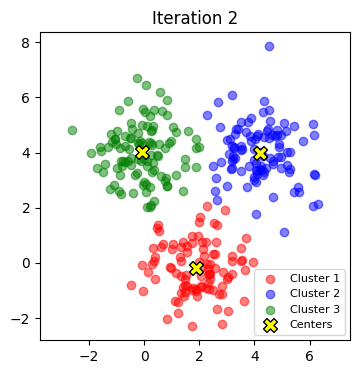

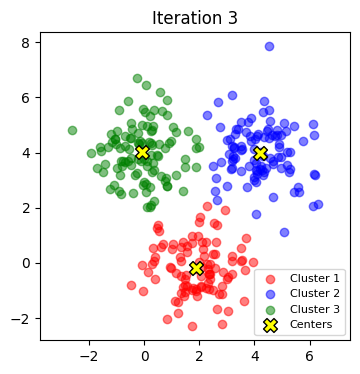

알고리즘이 3회 만에 수렴했습니다. (중심 이동량 0.00e+00)


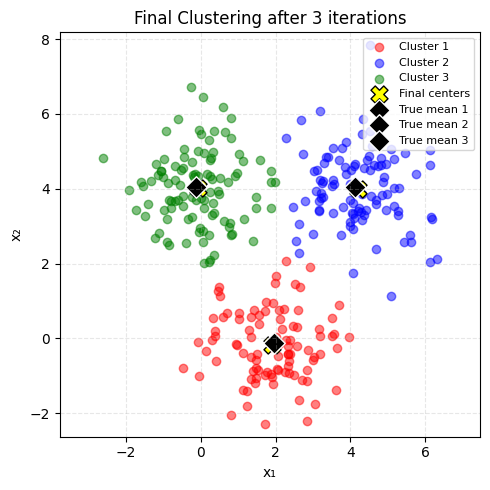

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) (2)에서 계산한 실제 클래스별 샘플 평균 다시 계산
# ------------------------------------------------------------
# np.mean으로 각 클래스 X1, X2, X3의 2차원 평균 구함
mu1_emp = np.mean(X1, axis=0)   # 클래스1 평균 (x₁, x₂)
mu2_emp = np.mean(X2, axis=0)   # 클래스2 평균
mu3_emp = np.mean(X3, axis=0)   # 클래스3 평균

# ------------------------------------------------------------
# 2) K-means 초기 설정
# ------------------------------------------------------------
max_iter = 10                   # 최대 반복 횟수 제한
rng = np.random.RandomState(0)  # 랜덤 시드 고정
n_samples = X.shape[0]          # 전체 샘플 수 (300)

# 2-1) 초기 중심값: 데이터 X 중 랜덤으로 3개 추출
init_idx = rng.choice(n_samples, 3, replace=False)
centers = X[init_idx]           # shape = (3,2)

# 2-2) 레이블 초기화 (0~2 클러스터)
labels = np.zeros(n_samples, dtype=int)

# ------------------------------------------------------------
# 3) K-means 반복 수행
# ------------------------------------------------------------
for it in range(max_iter):
    # --- 할당 단계 (Assignment) ---
    # 각 샘플을 가장 가까운 중심에 할당 (Euclidean 거리 기준)
    for j in range(n_samples):
        # 세 중심까지 거리 직접 계산 (조금 번거로운 방식)
        d0 = np.linalg.norm(X[j] - centers[0])
        d1 = np.linalg.norm(X[j] - centers[1])
        d2 = np.linalg.norm(X[j] - centers[2])
        # 가장 작은 거리를 가진 클러스터 인덱스 선택
        if d0 <= d1 and d0 <= d2:
            labels[j] = 0
        elif d1 <= d2:
            labels[j] = 1
        else:
            labels[j] = 2

    # --- 갱신 단계 (Update) ---
    # 각 클러스터 k의 새 중심을 계산
    new_centers = np.zeros_like(centers)   # 빈 배열 할당
    for k in range(3):
        # 클러스터 k에 속한 샘플만 골라 리스트로 만듦
        pts_k = [X[j] for j in range(n_samples) if labels[j] == k]
        if len(pts_k) > 0:
            # np.mean을 사용해 새로운 중심 좌표 계산
            new_centers[k] = np.mean(pts_k, axis=0)
        else:
            # 빈 클러스터인 경우, 기존 중심 유지
            new_centers[k] = centers[k]

    # --- 시각화: 현재 스텝의 군집과 중심 표시 ---
    plt.figure(figsize=(4,4))
    for k, color in enumerate(['r','b','g']):
        # 해당 클러스터에 할당된 점만 플롯
        idxs = (labels == k)
        plt.scatter(X[idxs,0], X[idxs,1],
                    c=color, alpha=0.5,
                    label=f'Cluster {k+1}')
    # 중심점은 노란색 X 마커로 표시
    plt.scatter(new_centers[:,0], new_centers[:,1],
                c='yellow', edgecolor='k',
                marker='X', s=100,
                label='Centers')
    plt.title(f'Iteration {it+1}')  # 반복 숫자 표시
    plt.axis('equal')
    plt.legend(loc='best', fontsize=8)
    plt.show()

    # --- 수렴 검사 (Convergence Check) ---
    # 중심 이동량 계산
    shift = np.linalg.norm(new_centers - centers)
    if shift < 1e-6:
        print(f"알고리즘이 {it+1}회 만에 수렴했습니다. (중심 이동량 {shift:.2e})")
        break

    # 다음 반복을 위해 중심 갱신
    centers = new_centers

# 실제 반복된 횟수는 it+1
n_iter = it + 1


# ------------------------------------------------------------
# 4) 최종 결과 플롯: 클러스터, 최종 중심, 실제 클래스 평균 비교
# ------------------------------------------------------------
plt.figure(figsize=(5,5))

# (4-1) 최종 클러스터 산점도
for k, color in enumerate(['r','b','g']):
    idxs = (labels == k)
    plt.scatter(X[idxs,0], X[idxs,1],
                c=color, alpha=0.5,
                label=f'Cluster {k+1}')

# (4-2) K-means가 찾은 최종 중심
plt.scatter(centers[:,0], centers[:,1],
            c='yellow', edgecolor='k',
            marker='X', s=150,
            label='Final centers')

# (4-3) (2)에서 계산한 실제 클래스 샘플 평균
plt.scatter(mu1_emp[0], mu1_emp[1],
            c='k', marker='D', s=120,
            edgecolor='white',
            label='True mean 1')
plt.scatter(mu2_emp[0], mu2_emp[1],
            c='k', marker='D', s=120,
            edgecolor='white',
            label='True mean 2')
plt.scatter(mu3_emp[0], mu3_emp[1],
            c='k', marker='D', s=120,
            edgecolor='white',
            label='True mean 3')

# 그래프 꾸미기
plt.title(f'Final Clustering after {n_iter} iterations')
plt.xlabel('x₁'); plt.ylabel('x₂')
plt.axis('equal')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
from google.colab import files

# 파일 선택창이 뜹니다. HW3Data.mat 파일 업로드
uploaded = files.upload()

KeyboardInterrupt: 

파일에 저장된 데이터셋 키: ['data']
원본 배열 형태: (2, 800)
산점도용 배열 형태: (800, 2)


<ipython-input-16-668416aa2de9>:46: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                       # 레이아웃 간격 자동 조정
<ipython-input-16-668416aa2de9>:46: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                       # 레이아웃 간격 자동 조정
<ipython-input-16-668416aa2de9>:46: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                       # 레이아웃 간격 자동 조정
<ipython-input-16-668416aa2de9>:46: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                       # 레이아웃 간격 자동 조정
<ipython-input-16-668416aa2de9>:46: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()                       # 레이아웃 간격 자동 조정


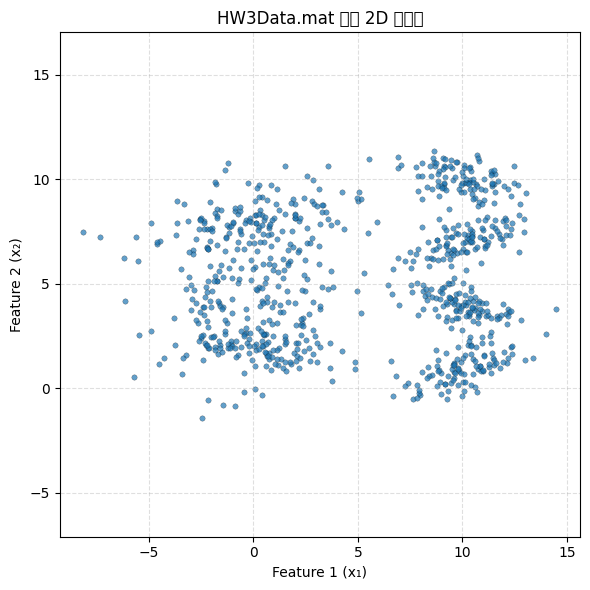

In [16]:
import h5py                 # HDF5 기반 MATLAB v7.3 파일을 읽기 위해 사용
import numpy as np         # 배열 연산 라이브러리
import matplotlib.pyplot as plt  # 시각화 라이브러리

# ------------------------------------------------------------
# 1) .mat 파일 열기
# ------------------------------------------------------------
# 'HW3Data.mat' 파일이 Colab의 /mnt/data 경로에 업로드되어 있다고 가정
# h5py.File: 파일 객체를 연 뒤 with 블록이 끝나면 자동으로 닫힘
with h5py.File('HW3Data.mat','r') as f:
    # 파일 내부 key 확인 (일반적으로 'data'라는 이름으로 저장됨)
    print("파일에 저장된 데이터셋 키:", list(f.keys()))
    # 데이터셋 'data' 읽어오기. 원본 형태는 (2, N)
    raw = f['data'][:]
    print("원본 배열 형태:", raw.shape)

# ------------------------------------------------------------
# 2) 데이터 전처리: 전치(transpose)하여 (N, 2) 형태로 변환
# ------------------------------------------------------------
# raw.T를 사용하면 shape=(800,2) 배열이 됨
X = raw.T
print("산점도용 배열 형태:", X.shape)

# ------------------------------------------------------------
# 3) 2D 산점도 그리기
# ------------------------------------------------------------
plt.figure(figsize=(6,6))         # 그래프 캔버스 크기 설정
plt.scatter(
    X[:, 0],                      # 모든 샘플의 첫 번째 차원 값 (x₁)
    X[:, 1],                      # 모든 샘플의 두 번째 차원 값 (x₂)
    c='tab:blue',                 # 점 색상
    s=15,                         # 점 크기(size)
    alpha=0.7,                    # 점 투명도
    edgecolor='k',                # 테두리 색상(선명도 강조용)
    linewidth=0.2                 # 테두리 두께
)

# ------------------------------------------------------------
# 4) 그래프 세부 설정
# ------------------------------------------------------------
plt.title('HW3Data.mat 샘플 2D 산점도')   # 제목
plt.xlabel('Feature 1 (x₁)')             # x축 레이블
plt.ylabel('Feature 2 (x₂)')             # y축 레이블
plt.grid(True, linestyle='--', alpha=0.4)  # 그리드 추가로 가독성 향상
plt.axis('equal')                        # x/y 축 눈금 비율을 동일하게 유지
plt.tight_layout()                       # 레이아웃 간격 자동 조정
plt.show()                               # 그래프 출력

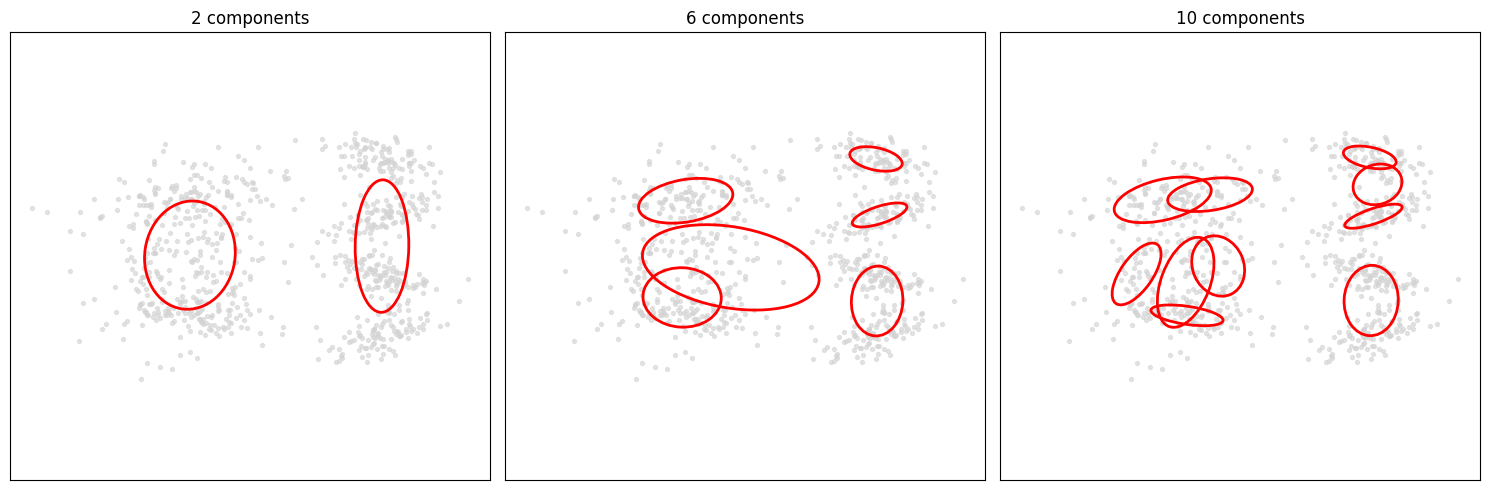

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# ------------------------------------------------------------
# (0) 데이터 준비
# ------------------------------------------------------------
# X는 앞서 불러온 HW3Data.mat에서 전치해 얻은 (N,2) 배열이라고 가정
# 만약 없다면 아래처럼 불러와 주세요.
# import scipy.io
# raw = scipy.io.loadmat('/mnt/data/HW3Data.mat')['data']
# X = raw.T

# ------------------------------------------------------------
# (1) 테스트할 가우시안 성분 수를 리스트로 정의
# ------------------------------------------------------------
component_list = [2, 6, 10]

# ------------------------------------------------------------
# (2) 전체 플롯 캔버스 설정 (가로: 성분 개수, 세로: 1)
# ------------------------------------------------------------
plt.figure(figsize=(15, 5))

# ------------------------------------------------------------
# (3) 성분 수별로 EM 알고리즘 수행
# ------------------------------------------------------------
for idx, K in enumerate(component_list):
    # --------------------------------------------------------
    # (3-1) 초기화: 혼합비(pis), 평균(mus), 공분산(covs)
    # --------------------------------------------------------
    N, D = X.shape
    pis = np.ones(K) / K                              # 혼합비 초기 균일분포
    rng = np.random.RandomState(0)                    # 재현을 위한 시드
    mus = X[rng.choice(N, K, replace=False)].copy()   # 랜덤 샘플로 평균 초기화
    covs = [np.eye(D) for _ in range(K)]              # 단위행렬로 공분산 초기화
    resp = np.zeros((N, K))                           # 책임도 행렬 초기화

    # --------------------------------------------------------
    # (3-2) EM 반복 (20회 고정)
    # --------------------------------------------------------
    for it in range(20):
        # --- E-step: 책임도 계산 ---
        for k in range(K):
            diff = X - mus[k]                         # 차이 행렬 (N×D)
            invC = np.linalg.inv(covs[k])             # 공분산 역행렬
            detC = np.linalg.det(covs[k])             # 공분산 행렬의 행렬식
            const = 1.0 / np.sqrt((2*np.pi)**D * detC)
            # 각 샘플에 대해 확률 밀도 직접 계산
            for i in range(N):
                resp[i, k] = pis[k] * const * \
                    np.exp(-0.5 * diff[i].dot(invC).dot(diff[i]))

        # 책임도 정규화: 행 단위 합이 1이 되도록
        resp = resp / resp.sum(axis=1, keepdims=True)

        # --- M-step: 파라미터 갱신 ---
        Nk = resp.sum(axis=0)                       # 유효 샘플 수 합
        pis = Nk / N                                 # 새로운 혼합비
        for k in range(K):
            # 새로운 평균: 책임도로 가중합 후 Nk로 나누기
            mus[k] = (resp[:, k][:, None] * X).sum(axis=0) / Nk[k]
            # 새로운 공분산: 책임도 가중 외적 합
            Ck = np.zeros((D, D))
            for i in range(N):
                d = (X[i] - mus[k])[:, None]
                Ck += resp[i, k] * (d @ d.T)
            covs[k] = Ck / Nk[k] + 1e-6 * np.eye(D)  # 수치안정화 항 추가

    # --------------------------------------------------------
    # (4) 결과 시각화: 전체 데이터 + 각 성분 타원 그리기
    # --------------------------------------------------------
    ax = plt.subplot(1, len(component_list), idx + 1)
    # (4-1) 데이터 산점도: 회색 점
    ax.scatter(X[:, 0], X[:, 1], c='lightgray', s=8, alpha=0.6)

    # (4-2) 각 성분별 가우시안 타원 그리기
    for k in range(K):
        # 공분산의 고유분해로 타원 형상 파라미터 얻기
        eigvals, eigvecs = np.linalg.eigh(covs[k])
        width, height = 2 * np.sqrt(eigvals)        # 반장축 길이
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        ell = Ellipse(mus[k], width, height, angle=angle,
                      edgecolor='red', facecolor='none', lw=2)
        ax.add_patch(ell)

    # (4-3) 서브플롯 꾸미기
    ax.set_title(f'{K} components')
    ax.axis('equal')
    ax.set_xticks([]); ax.set_yticks([])

# ------------------------------------------------------------
# (5) 레이아웃 정리 및 전체 플롯 표시
# ------------------------------------------------------------
plt.tight_layout()
plt.show()